## Setup

You will need to make a copy of this notebook in your Google Drive before you can edit the homework files. You can do so with **File &rarr; Save a copy in Drive**.

In [59]:
#@title mount your Google Drive
#@markdown Your work will be stored in a folder called `cds_rl_2022` by default to prevent Colab instance timeouts from deleting your edits.

import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [17]:
#@title set up mount symlink

DRIVE_PATH = '/content/gdrive/My\ Drive/cds_rl_2022'
DRIVE_PYTHON_PATH = DRIVE_PATH.replace('\\', '')
if not os.path.exists(DRIVE_PYTHON_PATH):
  !mkdir $DRIVE_PATH

## the space in `My Drive` causes some issues,
## make a symlink to avoid this
SYM_PATH = '/content/cds_rl_2022'
if not os.path.exists(SYM_PATH):
  !ln -s $DRIVE_PATH $SYM_PATH

In [18]:
#@title apt install requirements

#@markdown Run each section with Shift+Enter


#@markdown Double-click on section headers to show code.

!apt update 
!apt install -y --no-install-recommends \
        build-essential \
        curl \
        git \
        git-lfs \
        gnupg2 \
        make \
        cmake \
        ffmpeg \
        swig \
        libz-dev \
        unzip \
        zlib1g-dev \
        libglfw3 \
        libglfw3-dev \
        libxrandr2 \
        libxinerama-dev \
        libxi6 \
        libxcursor-dev \
        libgl1-mesa-dev \
        libgl1-mesa-glx \
        libglew-dev \
        libosmesa6-dev \
        lsb-release \
        ack-grep \
        patchelf \
        wget \
        xpra \
        xserver-xorg-dev \
        xvfb \
        python-opengl \
        ffmpeg

# set up git lfs
!git lfs install

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

In [19]:
#@title install mujoco-py

%pip install free-mujoco-py

# Cythonizes pkg on the first run
import mujoco_py

In [20]:
#@title clone homework repo and install all requirements

%cd $SYM_PATH
# !git clone https://github.com/pkuderov/mipt-rl-hw-2022.git rl_hw
%cd rl_hw/hw1
%pip install -r requirements.colab.txt
%pip install -e .

/content/gdrive/My Drive/cds_rl_2022
/content/gdrive/My Drive/cds_rl_2022/rl_hw/hw1
Obtaining file:///content/gdrive/My%20Drive/cds_rl_2022/rl_hw/hw1
  Attempting uninstall: cds-rl
    Found existing installation: cds-rl 1.0.0
    Can't uninstall 'cds-rl'. No files were found to uninstall.
  Running setup.py develop for cds-rl


In [21]:
#@title set up virtual display

from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

In [22]:
#@title test virtual display

#@markdown If you see a video of a four-legged ant fumbling about, setup is complete!

import gym
from cds_rl.infrastructure.colab_utils import (
    wrap_env,
    show_video
) 

env = wrap_env(gym.make("Ant-v2"))

observation = env.reset()
for i in range(100):
    env.render(mode='rgb_array')
    obs, rew, term, _ = env.step(env.action_space.sample() ) 
    if term:
      break;
            
env.close()
print('Loading video...')
show_video()

Loading video...


## Editing Code

To edit code, click the folder icon on the left menu. Navigate to the corresponding file (`cds_rl_2022/...`). Double click a file to open an editor. There is a timeout of about ~12 hours with Colab while it is active (and less if you close your browser window). We sync your edits to Google Drive so that you won't lose your work in the event of an instance timeout, but you will need to re-mount your Google Drive and re-install packages with every new instance.

## Run Behavior Cloning (Problem 1)

In [23]:
#@title imports

import os
import time
import numpy as np

from cds_rl.infrastructure.rl_trainer import RL_Trainer
from cds_rl.agents.bc_agent import BCAgent
from cds_rl.policies.loaded_gaussian_policy import LoadedGaussianPolicy

%load_ext autoreload
%autoreload 2

In [13]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cds_rl/policies/experts/Ant.pkl' #@param
  expert_data = 'cds_rl/expert_data/expert_data_Ant-v2.pkl' #@param
  env_name = 'Ant-v2' #@param ['Ant-v2', 'Humanoid-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2']
  exp_name = 'test_bc_ant' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 100000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers =  4#@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq =  -1#@param {type: "integer"}
  scalar_log_freq =  1#@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}

args = Args()


In [14]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        # AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent # TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        ################
        # RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) # TODO: look in here and implement this

        #######################
        # LOAD EXPERT POLICY
        #######################

        print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [15]:
#@title create directory for logging

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='/content/cds_rl_2022/hw1/data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

In [16]:
%%time
## run training
trainer = BC_Trainer(args)
trainer.run_training_loop()

########################
logging outputs to  /content/cds_rl_2022/hw1/data/q1_test_bc_ant_Ant-v2_22-05-2022_20-07-51
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Ant.pkl
obs (1, 111) (1, 111)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 4459.7724609375
Eval_StdReturn : 712.1804809570312
Eval_MaxReturn : 4950.037109375
Eval_MinReturn : 768.483154296875
Eval_AverageEpLen : 984.2058823529412
Train_AverageReturn : 4713.6533203125
Train_StdReturn : 12.196533203125
Train_MaxReturn : 4725.849609375
Train_MinReturn : 4701.45654296875
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 100.508056640625
Training Loss : 0.0014932571211829782
Initial_DataCollection_AverageReturn : 4713.6533203125
Done logging...


CPU times: user 1min 40s, sys: 348 ms, total: 1min 40s
Wall time: 1min 40s


### walker

In [40]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cds_rl/policies/experts/Walker2d.pkl' #@param
  expert_data = 'cds_rl/expert_data/expert_data_Walker2d-v2.pkl' #@param
  env_name = 'Walker2d-v2' #@param ['Ant-v2', 'Humanoid-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2']
  exp_name = 'test_bcwalker' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 10000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 10000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers =  4#@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq =  9#@param {type: "integer"}
  scalar_log_freq =  1#@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed =  228#@param {type: "integer"}

args = Args()


In [41]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        # AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent # TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        ################
        # RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) # TODO: look in here and implement this

        #######################
        # LOAD EXPERT POLICY
        #######################

        print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [42]:
#@title create directory for logging

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='/content/cds_rl_2022/hw1/data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

In [43]:
## run training
trainer = BC_Trainer(args)
trainer.run_training_loop()

########################
logging outputs to  /content/cds_rl_2022/hw1/data/q1_test_bcwalker_Walker2d-v2_22-05-2022_20-44-47
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Walker2d.pkl
obs (1, 17) (1, 17)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 2730.468505859375
Eval_StdReturn : 1293.3822021484375
Eval_MaxReturn : 5266.4501953125
Eval_MinReturn : 1097.931640625
Eval_AverageEpLen : 568.4444444444445
Train_AverageReturn : 5566.845703125
Train_StdReturn : 9.237548828125
Train_MaxReturn : 5576.08349609375
Train_MinReturn : 5557.6083984375
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 28.50238537788391
Training Loss : 0.0018361406400799751
Initial_DataCollection_AverageReturn : 5566.845703125
Done logging...




## Behavioral Cloning, исследование гиперпараметров

In [27]:
class Args_n:

  def __init__(self, num_agent_train_steps_per_iter = 1000):
    self.num_agent_train_steps_per_iter = num_agent_train_steps_per_iter
  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cds_rl/policies/experts/Walker2d.pkl' #@param
  expert_data = 'cds_rl/expert_data/expert_data_Walker2d-v2.pkl' #@param
  env_name = 'Walker2d-v2' #@param ['Ant-v2', 'Humanoid-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2']
  exp_name = 'hp_test_bcwalker' #@param
  do_dagger = False #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

#   num_agent_train_steps_per_iter = 10000 #@param {type: "integer"})
  n_iter = 1 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 10000 #@param {type: "integer"}
  train_batch_size = 1001 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers =  4#@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq =  -1#@param {type: "integer"}
  scalar_log_freq =  1#@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed =  228#@param {type: "integer"}

  logdir = '/content/cds_rl_2022/hw1/data/'+'q1_' + 'hp_test_bcwalker' + '_' + 'walker' + '_'

In [28]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        # AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent # TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        ################
        # RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) # TODO: look in here and implement this

        #######################
        # LOAD EXPERT POLICY
        #######################

        # print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        # print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [29]:
## run training
args_s = [(i, Args_n(i)) for i in [10, 100, 1000, 10000]]
for i, args in args_s:
    trainer = BC_Trainer(args)
    trainer.run_training_loop()

########################
logging outputs to  /content/cds_rl_2022/hw1/data/q1_hp_test_bcwalker_walker_
########################
Using GPU id 0
obs (1, 17) (1, 17)


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 1477.0521240234375
Eval_StdReturn : 2088.616455078125
Eval_MaxReturn : 5341.83251953125
Eval_MinReturn : 212.0707244873047
Eval_AverageEpLen : 325.741935483871
Train_AverageReturn : 5566.845703125
Train_StdReturn : 9.237548828125
Train_MaxReturn : 5576.08349609375
Train_MinReturn : 5557.6083984375
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 9.713696002960205
Training Loss : 0.008747640065848827
Initial_DataCollection_AverageReturn : 5566.845703125
Done logging...


########################
logging outputs to  /content/cds_rl_2022/hw1/data/q1_hp_test_bcwalker_walker_
########################
Using GPU id 0
obs (1, 17) (1, 17)


********** Iteration 0 *****

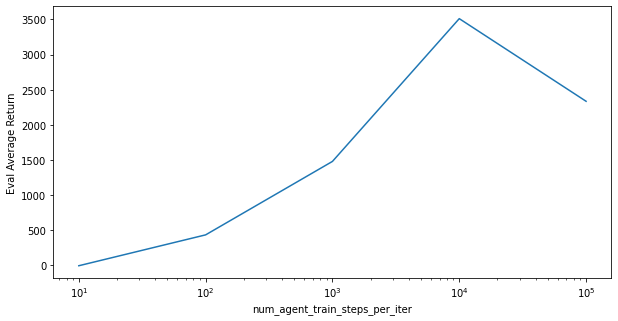

In [35]:
import matplotlib.pyplot as plt

y = [-10.1, 430, 1477, 3512, 2334]
y_lab = "Eval Average Return"
x = [10, 100, 1000, 10000, 100000]
x_lab = "num_agent_train_steps_per_iter"

plt.figure(figsize=(10, 5))
plt.plot(x, y)
plt.xlabel(x_lab)
plt.ylabel(y_lab)
plt.xscale("log")

## Tensorboard

In [9]:
#@markdown You can visualize your runs with tensorboard from within the notebook
%load_ext tensorboard
%tensorboard --logdir /content/cds_rl_2022/hw1/data

/bin/bash: line 0: kill: (4531) - No such process
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4531), started 1:46:57 ago. (Use '!kill 4531' to kill it.)

<IPython.core.display.Javascript object>

## Running DAgger (Problem 2)
Modify the settings above:
1. check the `do_dagger` box
2. set `n_iters` to `10`
and then rerun the code.

In [36]:
#@title runtime arguments

class Args:

  def __getitem__(self, key):
    return getattr(self, key)

  def __setitem__(self, key, val):
    setattr(self, key, val)

  #@markdown expert data
  expert_policy_file = 'cds_rl/policies/experts/Ant.pkl' #@param
  expert_data = 'cds_rl/expert_data/expert_data_Ant-v2.pkl' #@param
  env_name = 'Ant-v2' #@param ['Ant-v2', 'Humanoid-v2', 'Walker2d-v2', 'HalfCheetah-v2', 'Hopper-v2']
  exp_name = 'test_bc_ant' #@param
  do_dagger = True #@param {type: "boolean"}
  ep_len = 1000 #@param {type: "integer"}
  save_params = False #@param {type: "boolean"}

  num_agent_train_steps_per_iter = 1000 #@param {type: "integer"})
  n_iter = 10 #@param {type: "integer"})

  #@markdown batches & buffers
  batch_size = 1000 #@param {type: "integer"})
  eval_batch_size = 10000 #@param {type: "integer"}
  train_batch_size = 100 #@param {type: "integer"}
  max_replay_buffer_size = 1000000 #@param {type: "integer"}

  #@markdown network
  n_layers = 2 #@param {type: "integer"}
  size = 64 #@param {type: "integer"}
  learning_rate = 5e-3 #@param {type: "number"}

  #@markdown logging
  video_log_freq =  -1#@param {type: "integer"}
  scalar_log_freq =  1#@param {type: "integer"}

  #@markdown gpu & run-time settings
  no_gpu = False #@param {type: "boolean"}
  which_gpu = 0 #@param {type: "integer"}
  seed = 1 #@param {type: "integer"}

args = Args()


In [37]:
#@title define `BC_Trainer`
class BC_Trainer(object):

    def __init__(self, params):
        #######################
        # AGENT PARAMS
        #######################

        agent_params = {
            'n_layers': params['n_layers'],
            'size': params['size'],
            'learning_rate': params['learning_rate'],
            'max_replay_buffer_size': params['max_replay_buffer_size'],
            }

        self.params = params
        self.params['agent_class'] = BCAgent # TODO: look in here and implement this
        self.params['agent_params'] = agent_params

        ################
        # RL TRAINER
        ################

        self.rl_trainer = RL_Trainer(self.params) # TODO: look in here and implement this

        #######################
        # LOAD EXPERT POLICY
        #######################

        print('Loading expert policy from...', self.params['expert_policy_file'])
        self.loaded_expert_policy = LoadedGaussianPolicy(self.params['expert_policy_file'])
        print('Done restoring expert policy...')

    def run_training_loop(self):

        self.rl_trainer.run_training_loop(
            n_iter=self.params['n_iter'],
            initial_expertdata=self.params['expert_data'],
            collect_policy=self.rl_trainer.agent.actor,
            eval_policy=self.rl_trainer.agent.actor,
            relabel_with_expert=self.params['do_dagger'],
            expert_policy=self.loaded_expert_policy,
        )


In [38]:
#@title create directory for logging

if args.do_dagger:
    logdir_prefix = 'q2_'  # The autograder uses the prefix `q2_`
    assert args.n_iter>1, ('DAgger needs more than 1 iteration (n_iter>1) of training, to iteratively query the expert and train (after 1st warmstarting from behavior cloning).')
else:
    logdir_prefix = 'q1_'  # The autograder uses the prefix `q1_`
    assert args.n_iter==1, ('Vanilla behavior cloning collects expert data just once (n_iter=1)')

data_path ='/content/cds_rl_2022/hw1/data'
if not (os.path.exists(data_path)):
    os.makedirs(data_path)
logdir = logdir_prefix + args.exp_name + '_' + args.env_name + \
         '_' + time.strftime("%d-%m-%Y_%H-%M-%S")
logdir = os.path.join(data_path, logdir)
args['logdir'] = logdir
if not(os.path.exists(logdir)):
    os.makedirs(logdir)

In [39]:
## run training
trainer = BC_Trainer(args)
trainer.run_training_loop()

########################
logging outputs to  /content/cds_rl_2022/hw1/data/q2_test_bc_ant_Ant-v2_22-05-2022_21-27-06
########################
Using GPU id 0
Loading expert policy from... cds_rl/policies/experts/Ant.pkl
obs (1, 111) (1, 111)
Done restoring expert policy...


********** Iteration 0 ************

Training agent using sampled data from replay buffer...

Beginning logging procedure...

Eval_AverageReturn : 4237.943359375
Eval_StdReturn : 1042.2493896484375
Eval_MaxReturn : 4945.31640625
Eval_MinReturn : 1527.9185791015625
Eval_AverageEpLen : 962.0909090909091
Train_AverageReturn : 4713.6533203125
Train_StdReturn : 12.196533203125
Train_MaxReturn : 4725.849609375
Train_MinReturn : 4701.45654296875
Train_AverageEpLen : 1000.0
Train_EnvstepsSoFar : 0
TimeSinceStart : 10.989105224609375
Training Loss : 0.0013770797522738576
Initial_DataCollection_AverageReturn : 4713.6533203125
Done logging...




********** Iteration 1 ************


Relabelling collected observations with lab

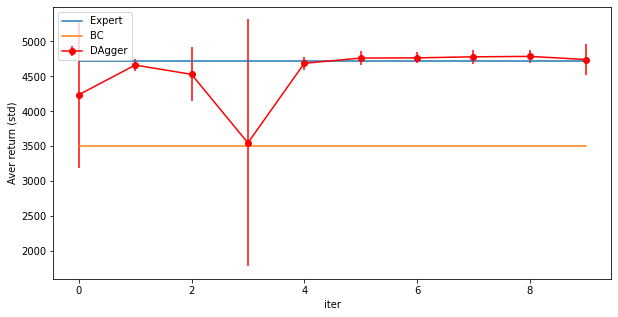

In [49]:
aver_return = [4237, 4662, 4529, 3548, 4687, 4762, 4765, 4780, 4786, 4741]
std = [1042, 91, 388, 1768, 97, 97, 77, 98, 96, 219]
x = range(10)
plt.figure(figsize=(10, 5))
plt.plot([4713]*len(aver_return), label="Expert")
plt.plot([3500]*len(aver_return), label="BC")
plt.errorbar(x, aver_return, yerr=std, fmt='-ro', label="DAgger")
plt.xlabel("iter")
plt.ylabel("Aver return (std)")
plt.legend()

In [56]:
!cd ../../hw1/data &&  ls

hw1  rl_hw


In [58]:
!mv ../../hw1/data ./
